In [1]:
import numpy as np
import cv2
import os
import pandas as pd
import string
import matplotlib.pyplot as plt

from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, LSTM, Reshape, BatchNormalization, Input, Conv2D, MaxPool2D, Lambda, Bidirectional
from keras.models import Model
from keras.activations import relu, sigmoid, softmax
import keras.backend as K
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
from keras_tqdm import TQDMNotebookCallback

from tensorflow.keras import backend as K
from tensorflow.keras.backend import ctc_batch_cost
from tensorflow.keras.saving import register_keras_serializable

from tensorflow.keras.models import load_model
import tensorflow.keras as keras
from tensorflow.keras.backend import ctc_batch_cost
from tensorflow.keras.saving import register_keras_serializable

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf


In [2]:

# Set the path to the folder
folder_path = r'C:\Users\sweth\Neural\DomainAdaptation'

with open(f'{folder_path}/words.txt', 'r') as f:
    contents = f.readlines()

lines = [line.strip() for line in contents]

max_label_len = 0

char_list = "!\"#&'()*+,-./0123456789:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz"

# Print character list
print(char_list, len(char_list))

def encode_to_labels(txt):
    """Encoding output word into digits"""
    dig_lst = []
    for index, chara in enumerate(txt):
        dig_lst.append(char_list.index(chara))
    return dig_lst

images = []
labels = []

# Sample records limit
RECORDS_COUNT = 10000

train_images = []
train_labels = []
train_input_length = []
train_label_length = []
train_original_text = []

valid_images = []
valid_labels = []
valid_input_length = []
valid_label_length = []
valid_original_text = []

inputs_length = []
labels_length = []


!"#&'()*+,-./0123456789:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz 78


Preprocess Training Images

In [3]:

def process_image(img):
    """
    Converts image to shape (32, 128, 1) & normalize
    """
    w, h = img.shape

    # Aspect Ratio Calculation
    new_w = 32
    new_h = int(h * (new_w / w))
    img = cv2.resize(img, (new_h, new_w))
    w, h = img.shape

    img = img.astype('float32')

    # Converts each to (32, 128, 1)
    if w < 32:
        add_zeros = np.full((32-w, h), 255)
        img = np.concatenate((img, add_zeros))
        w, h = img.shape

    if h < 128:
        add_zeros = np.full((w, 128-h), 255)
        img = np.concatenate((img, add_zeros), axis=1)
        w, h = img.shape

    if h > 128 or w > 32:
        dim = (128,32)
        img = cv2.resize(img, dim)

    img = cv2.subtract(255, img)

    img = np.expand_dims(img, axis=2)

    # Normalize
    img = img / 255

    return img


Split IAM datatset into Training and Validation sets

In [ ]:

# Process each line in words.txt for training and validation
for index, line in enumerate(lines):
    splits = line.split(' ')
    if len(splits) < 9 or splits[1] != 'ok':  # Skip invalid lines
        continue

    word_id = splits[0]
    word = "".join(splits[8:])

    splits_id = word_id.split('-')
    filepath = os.path.join(folder_path, 'words', f'{splits_id[0]}/{splits_id[0]}-{splits_id[1]}/{word_id}.png')

    img = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)
    if img is None:
        continue

    img = process_image(img)  # Process image
    label = encode_to_labels(word)  # Encode label

    if index % 10 == 0:
            valid_images.append(img)
            valid_labels.append(label)
            valid_input_length.append(31)
            valid_label_length.append(len(word))
            valid_original_text.append(word)
    else:
            train_images.append(img)
            train_labels.append(label)
            train_input_length.append(31)
            train_label_length.append(len(word))
            train_original_text.append(word)

    if len(word) > max_label_len:
            max_label_len = len(word)

    if index >= 10000:  # Limit to 10,000 samples for testing
        break

# Determine max label length
max_label_len = max(len(label) for label in train_labels)

# Pad labels
train_padded_label = pad_sequences(train_labels, maxlen=max_label_len, padding='post', value=len(char_list))
valid_padded_label = pad_sequences(valid_labels, maxlen=max_label_len, padding='post', value=len(char_list))

print("Train labels shape:", train_padded_label.shape)
print("Validation labels shape:", valid_padded_label.shape)

train_padded_label.shape, valid_padded_label.shape



In [4]:

# Convert images to numpy arrays
train_images = np.asarray(train_images)
train_input_length = np.asarray(train_input_length)
train_label_length = np.asarray(train_label_length)

valid_images = np.asarray(valid_images)
valid_input_length = np.asarray(valid_input_length)
valid_label_length = np.asarray(valid_label_length)

train_images.shape

(0,)

CRNN Architecture

In [ ]:
# input with shape of height=32 and width=128 
inputs = Input(shape=(32,128,1))
 
# convolution layer with kernel size (3,3)
conv_1 = Conv2D(64, (3,3), activation = 'relu', padding='same')(inputs)
# pooling layer with kernel size (2,2)
pool_1 = MaxPool2D(pool_size=(2, 2), strides=2)(conv_1)
 
conv_2 = Conv2D(128, (3,3), activation = 'relu', padding='same')(pool_1)
pool_2 = MaxPool2D(pool_size=(2, 2), strides=2)(conv_2)
 
conv_3 = Conv2D(256, (3,3), activation = 'relu', padding='same')(pool_2)
 
conv_4 = Conv2D(256, (3,3), activation = 'relu', padding='same')(conv_3)
# poolig layer with kernel size (2,1)
pool_4 = MaxPool2D(pool_size=(2, 1))(conv_4)
 
conv_5 = Conv2D(512, (3,3), activation = 'relu', padding='same')(pool_4)
# Batch normalization layer
batch_norm_5 = BatchNormalization()(conv_5)
 
conv_6 = Conv2D(512, (3,3), activation = 'relu', padding='same')(batch_norm_5)
batch_norm_6 = BatchNormalization()(conv_6)
pool_6 = MaxPool2D(pool_size=(2, 1))(batch_norm_6)
 
conv_7 = Conv2D(512, (2,2), activation = 'relu')(pool_6)
 
# squeezed = Lambda(lambda x: K.squeeze(x, 1))(conv_7)
squeezed = Lambda(lambda x: K.squeeze(x, 1), output_shape=(31, 512))(conv_7)

 
# bidirectional LSTM layers with units=128
blstm_1 = Bidirectional(LSTM(256, return_sequences=True, dropout = 0.2))(squeezed)
blstm_2 = Bidirectional(LSTM(256, return_sequences=True, dropout = 0.2))(blstm_1)
 
outputs = Dense(len(char_list)+1, activation = 'softmax')(blstm_2)

# model to be used at test time
act_model = Model(inputs, outputs)

In [6]:
the_labels = Input(name='the_labels', shape=[max_label_len], dtype='float32')
input_length = Input(name='input_length', shape=[1], dtype='int64')
label_length = Input(name='label_length', shape=[1], dtype='int64')

@register_keras_serializable()
def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

loss_out = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([outputs, the_labels, input_length, label_length])

#model to be used at training time
model = Model(inputs=[inputs, the_labels, input_length, label_length], outputs=loss_out)

In [7]:
batch_size = 8
epochs = 60
e = str(epochs)
optimizer_name = 'adam'

Model Saving

In [ ]:
import os
from tensorflow.keras.callbacks import ModelCheckpoint

model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer = optimizer_name, metrics=['accuracy'])

# Define the directory
save_dir = r"C:\Users\sweth\Neural\DomainAdaptation"

# Ensure the directory exists
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# Save the model architecture to a JSON file
model_json_path = os.path.join(save_dir, "model_architecture.json")
model_json = model.to_json()
with open(model_json_path, "w") as json_file:
    json_file.write(model_json)

# Save weights using ModelCheckpoint
weights_filepath = os.path.join(
    save_dir,
    "model.keras".format(
        optimizer_name,
        str(RECORDS_COUNT),
        str(epochs),
        str(train_images.shape[0]),
        str(valid_images.shape[0])
    )
)
checkpoint = ModelCheckpoint(
    filepath=weights_filepath,
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    mode='auto'
)
callbacks_list = [checkpoint]


Model Training

In [ ]:
history = model.fit(x=[train_images, train_padded_label, train_input_length, train_label_length],
                    y=np.zeros(len(train_images)),
                    batch_size=batch_size, 
                    epochs=epochs, 
                    validation_data=([valid_images, valid_padded_label, valid_input_length, valid_label_length], [np.zeros(len(valid_images))]),
                    verbose=1,callbacks=callbacks_list)

Prediction on validation set

In [ ]:
# Predict outputs on validation images
prediction = act_model.predict(train_images[150:170])

# Use CTC decoder
decoded = K.ctc_decode(prediction,
                       input_length=np.ones(prediction.shape[0]) * prediction.shape[1],
                       greedy=True)[0][0]

# Get the decoded values
out = K.get_value(decoded)

# Debugging: Check if out is populated
print("Length of decoded output (predictions):", len(out))

# If train_original_text is empty, handle it gracefully
if len(train_original_text) == 0:
    print("Warning: train_original_text is empty. No original texts to compare.")
else:
    # Loop through the outputs only if train_original_text has entries
    for i in range(min(len(out), len(train_original_text) - 150)):
        print("original_text =  ", train_original_text[150 + i])
        print("predicted text = ", end='')
        for p in out[i]:
            if int(p) != -1:
                print(char_list[int(p)], end='')
        plt.imshow(train_images[150 + i].reshape(32, 128), cmap=plt.cm.gray)
        plt.show()
        print('\n')


Re-loading model

In [11]:
weights_filepath = r"C:\Users\sweth\Neural\DomainAdaptation\model.keras"
model.load_weights(weights_filepath)
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=optimizer_name, metrics=['accuracy'])

Symspell with beam decoding 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


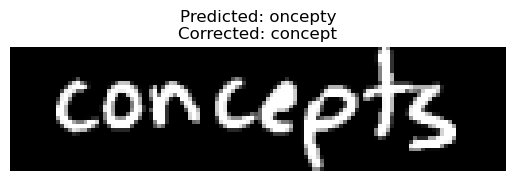

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


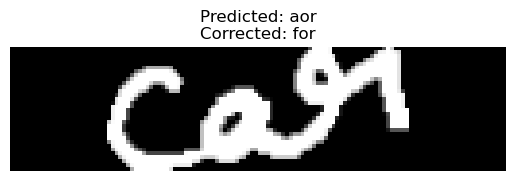

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


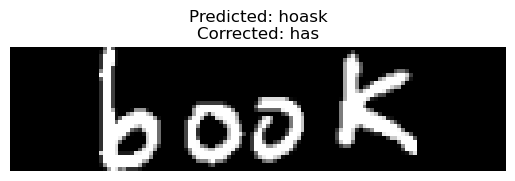

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


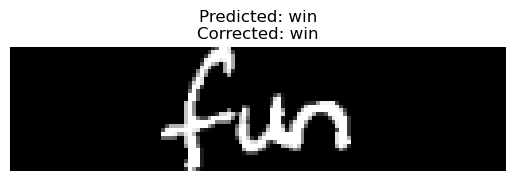

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


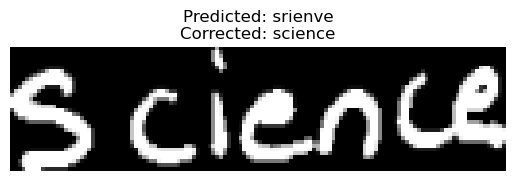

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


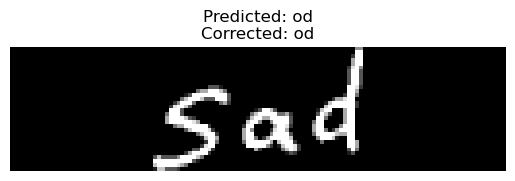

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


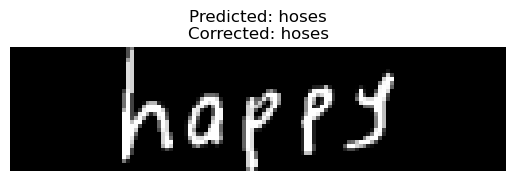

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


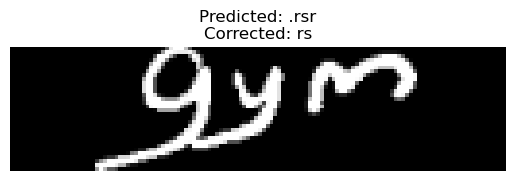

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


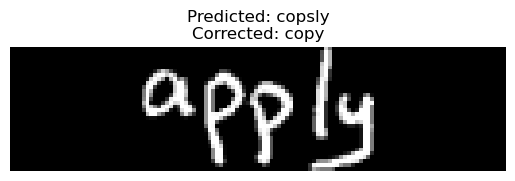

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


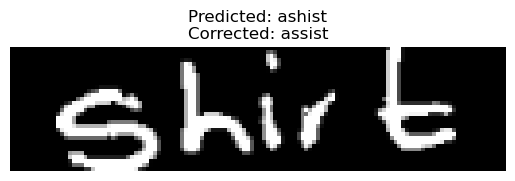

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


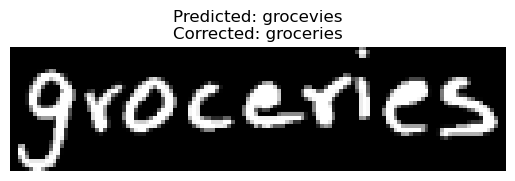

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


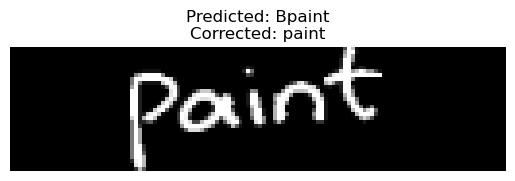

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


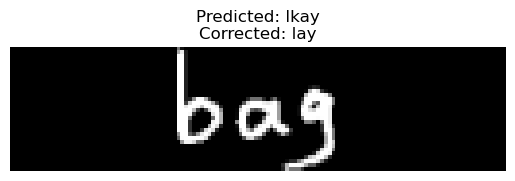

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


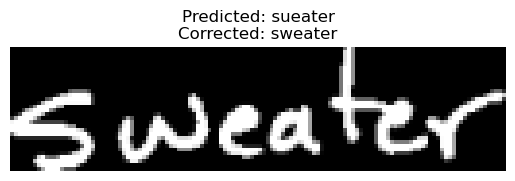

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


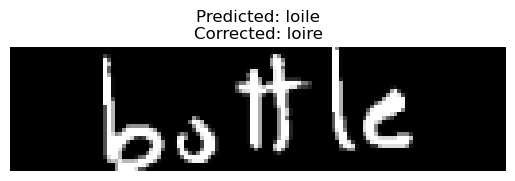

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


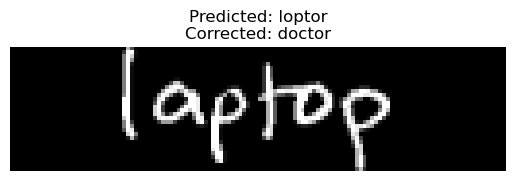

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


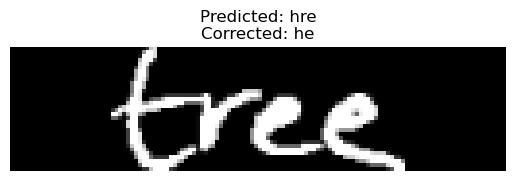

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


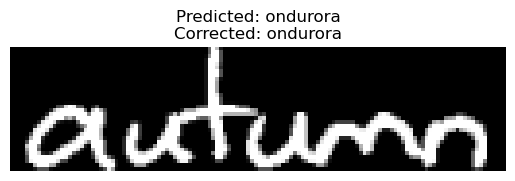

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


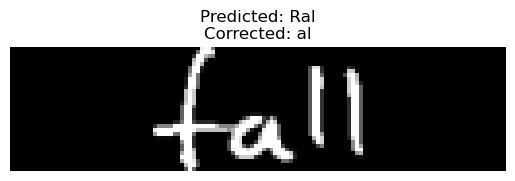

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


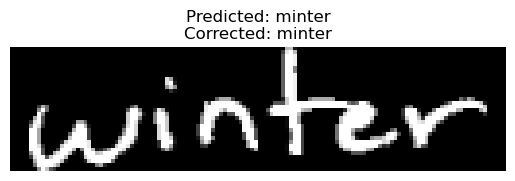

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


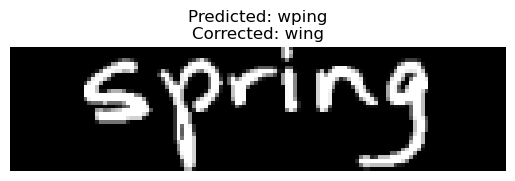

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


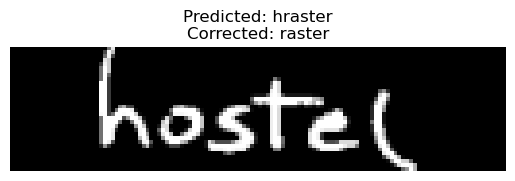

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


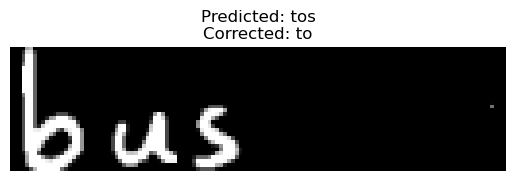

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


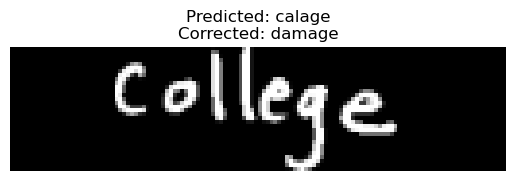

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


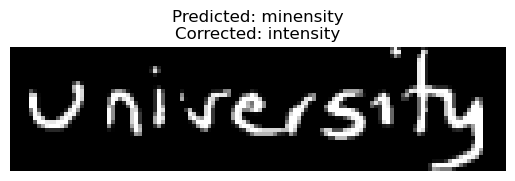

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


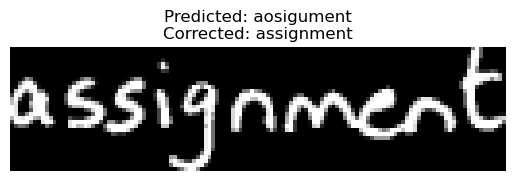

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


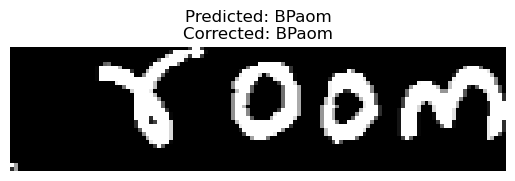

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


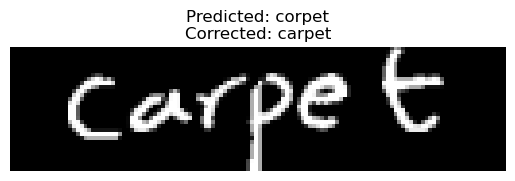

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


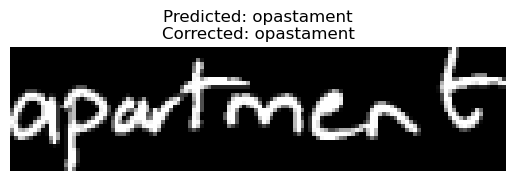

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


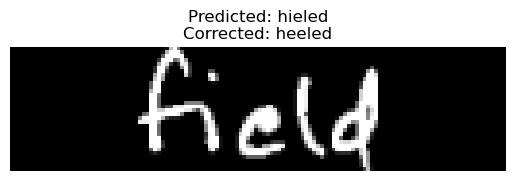

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


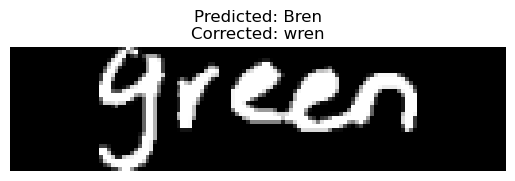

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


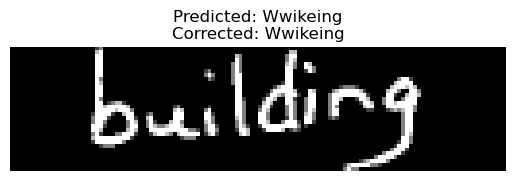

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


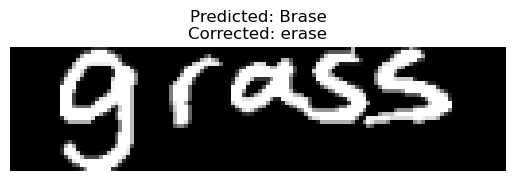

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


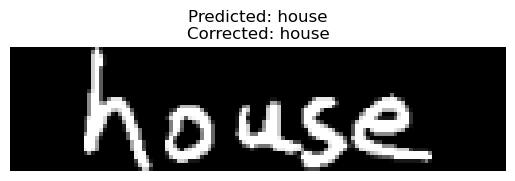

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


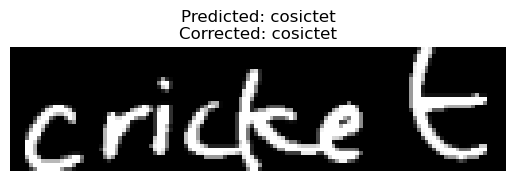

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


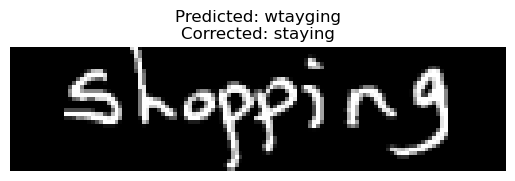

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


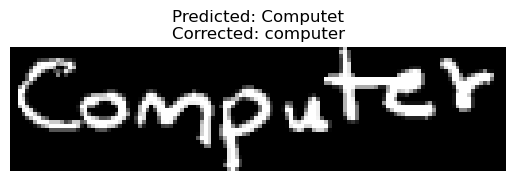

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


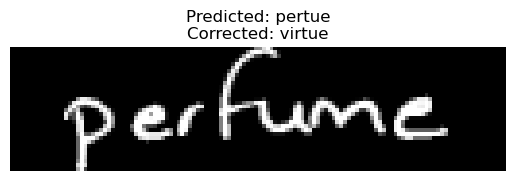

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


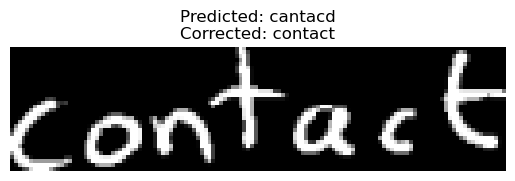

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


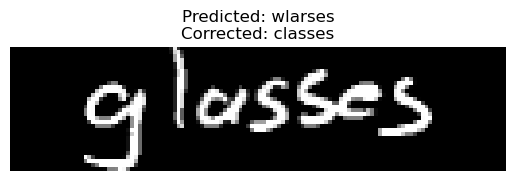

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


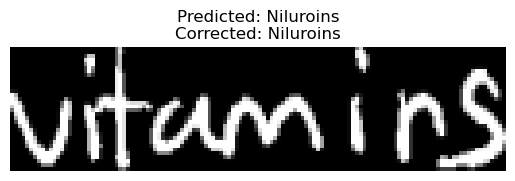

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


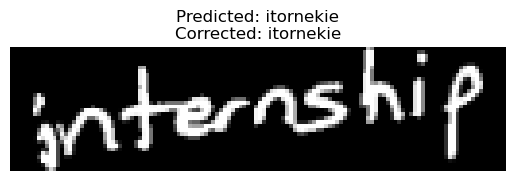

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


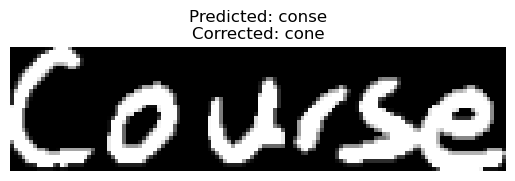

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


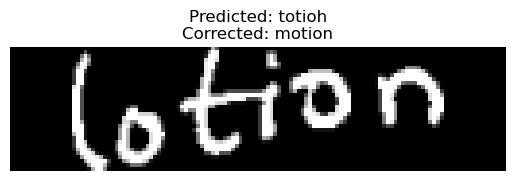

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


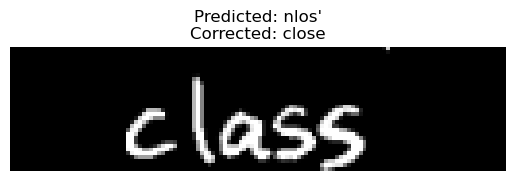

In [26]:
def predict_and_display_new_images_with_beam_search_and_symspell(model, char_list, sym_spell, folder_path=new_folder_path, beam_width=5):
    """
    Predict and display new images using beam search decoding and spell correction.
    :param model: Trained model for text prediction.
    :param char_list: List of characters corresponding to model output indices.
    :param sym_spell: SymSpell object for spell correction.
    :param folder_path: Path to the folder containing new images.
    :param beam_width: Beam width for beam search decoding.
    :return: List of corrected texts.
    """
    # Load new images from folder
    corrected_texts = []
    for filename in os.listdir(folder_path):
        if filename.endswith(".png"):
            # Read and preprocess the image
            img_path = os.path.join(folder_path, filename)
            processed_img = preprocess_image(img_path)  # Process to (32, 128, 1) as expected by the model

            # Expand dimensions to match model input
            processed_img = np.expand_dims(processed_img, axis=0)  # Shape: (1, 32, 128, 1)

            # Predict using the trained model
            prediction = model.predict(processed_img)

            # Decode prediction using CTC beam search decoder
            decoded_sequences, log_probs = K.ctc_decode(
                prediction, 
                input_length=np.ones(prediction.shape[0]) * prediction.shape[1],
                greedy=False,  # Enable beam search
                beam_width=beam_width
            )
            decoded_sequences = K.get_value(decoded_sequences[0])

            # Convert decoded labels back to text
            predicted_text = ''.join([char_list[c] for c in decoded_sequences[0] if c != -1])

            # Correct the spelling of the predicted text using SymSpell
            corrected_text = correct_spelling_with_symspell(predicted_text, sym_spell)

            # Display the original processed image for visualization
            plt.imshow(processed_img[0, :, :, 0], cmap='gray')  # Display the processed image
            plt.axis('off')
            plt.title(f"Predicted: {predicted_text}\nCorrected: {corrected_text}")
            plt.show()

            # Append corrected text to the list
            corrected_texts.append(corrected_text)
    
    return corrected_texts  # Return the list of corrected texts

# Call the updated function with your trained model, character list, and SymSpell
corrected_texts = predict_and_display_new_images_with_beam_search_and_symspell(act_model, char_list, sym_spell, beam_width=10)


Confidence score

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


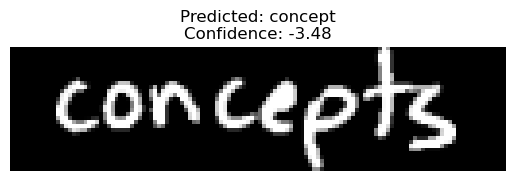

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


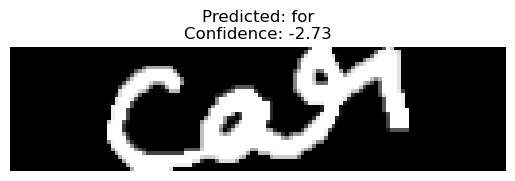

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


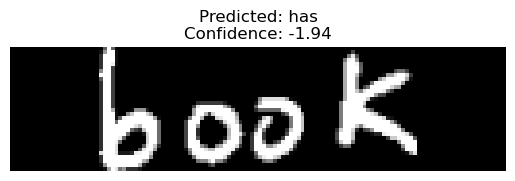

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


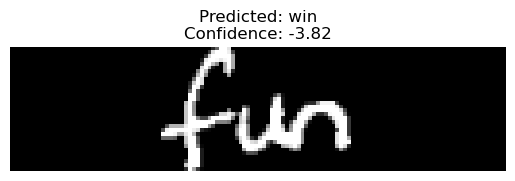

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


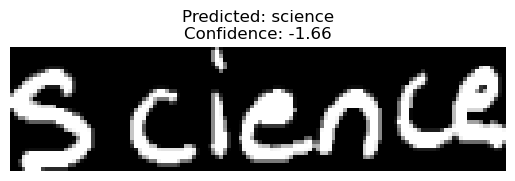

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


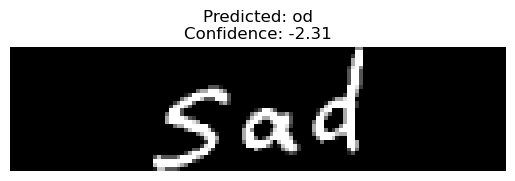

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


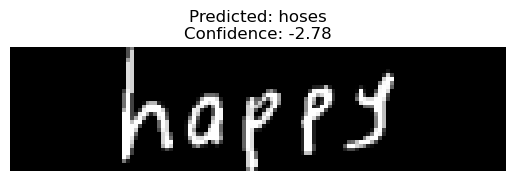

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


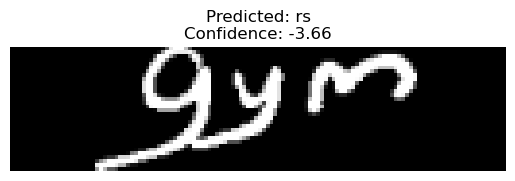

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


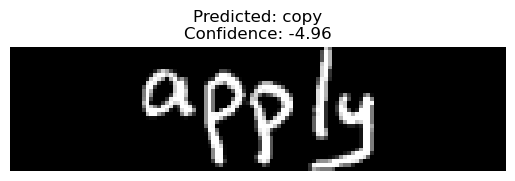

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


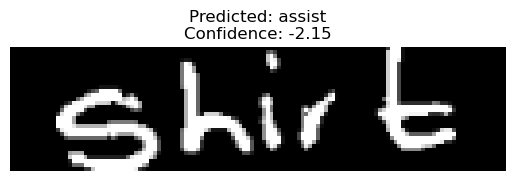

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


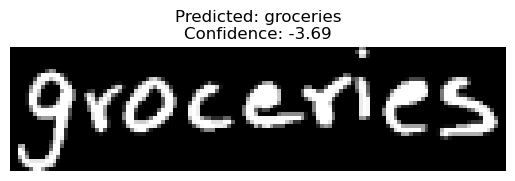

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


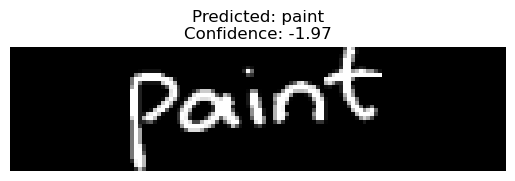

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


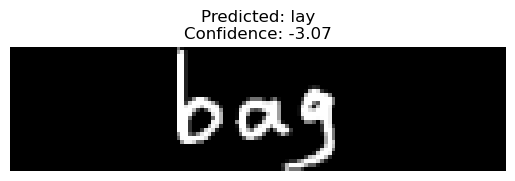

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


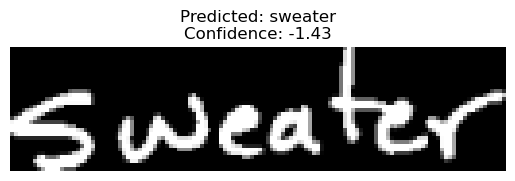

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


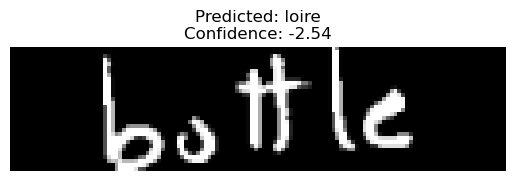

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


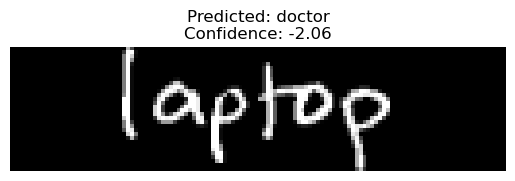

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


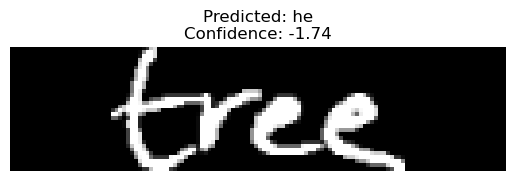

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


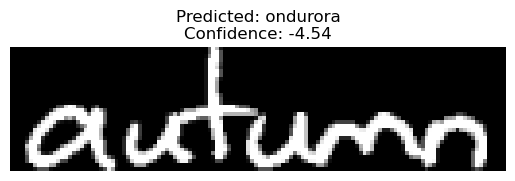

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


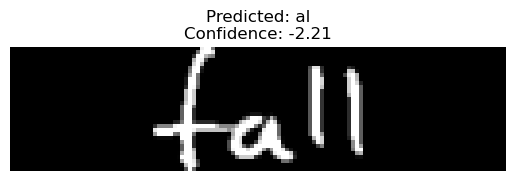

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


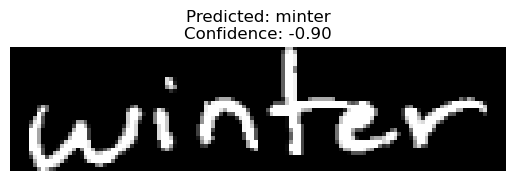

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


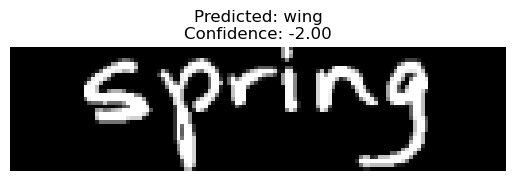

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


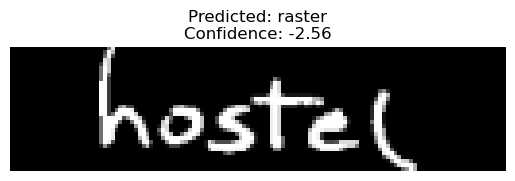

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


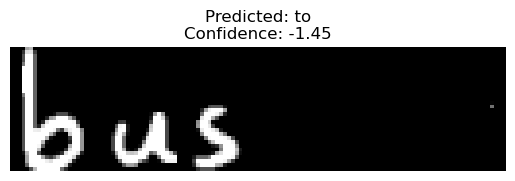

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


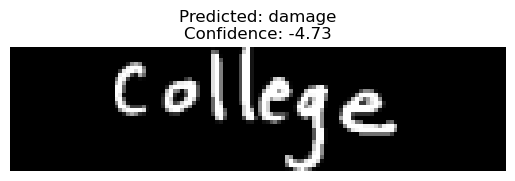

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


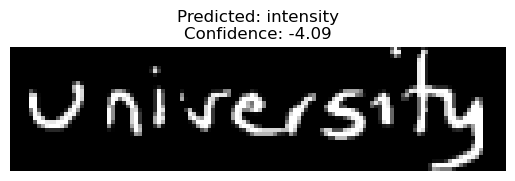

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


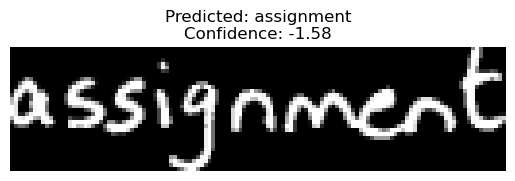

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


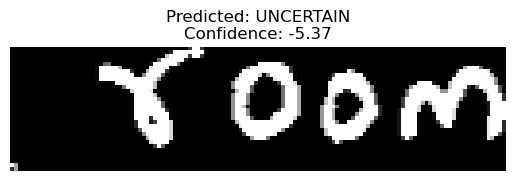

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


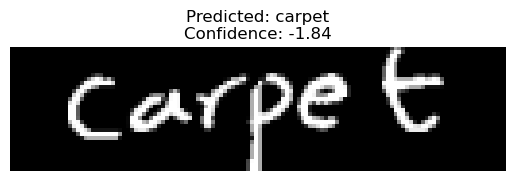

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


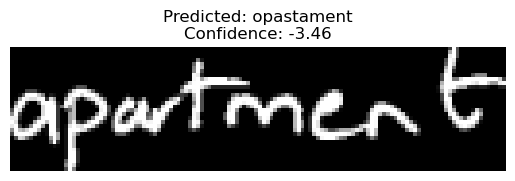

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


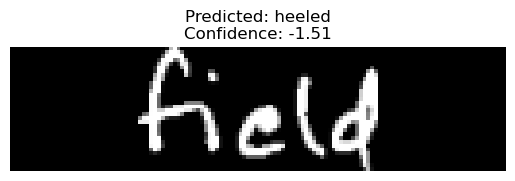

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


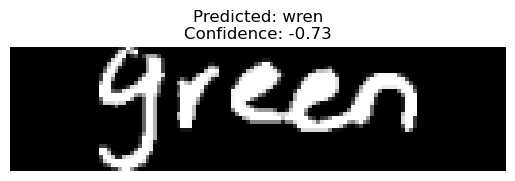

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


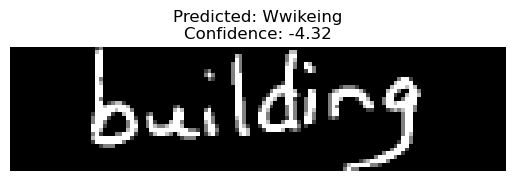

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


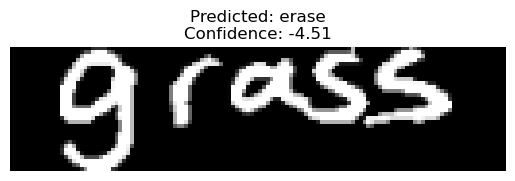

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


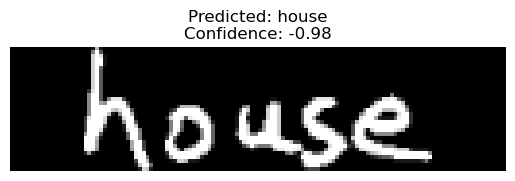

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


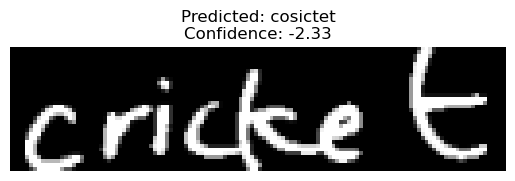

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


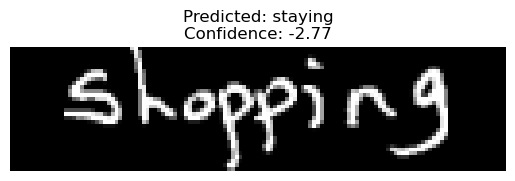

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


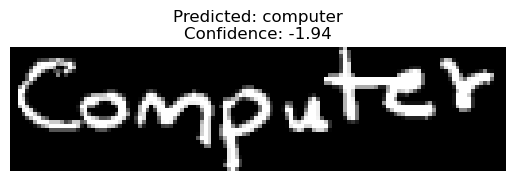

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


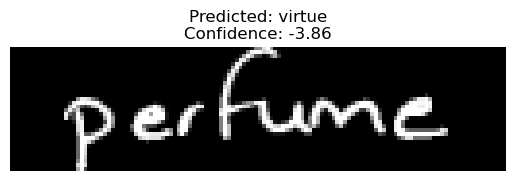

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


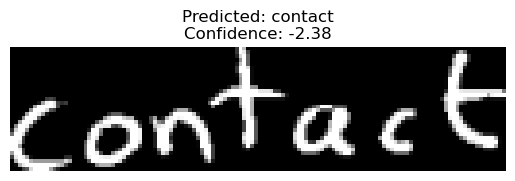

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


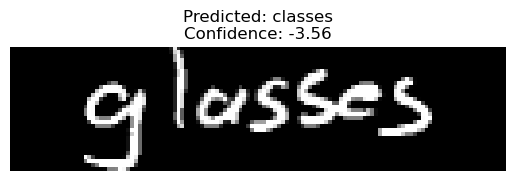

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


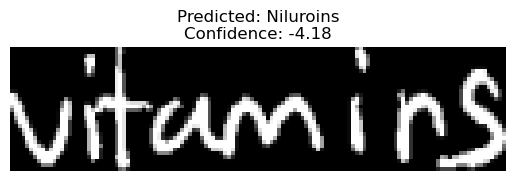

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


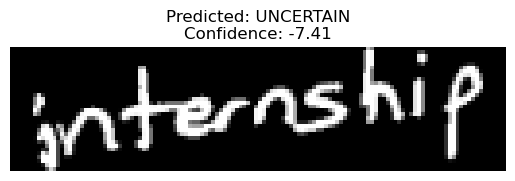

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


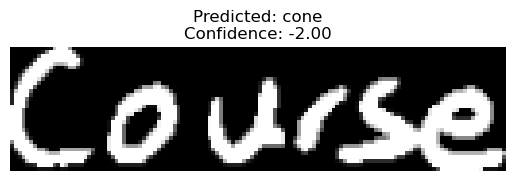

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


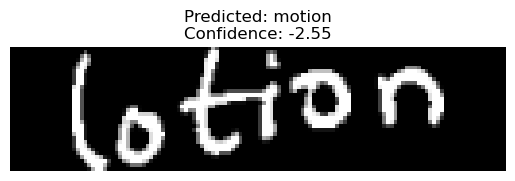

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


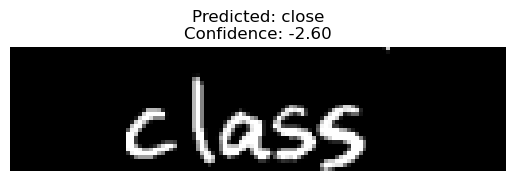

In [27]:
def predict_and_display_with_confidence_filtering(
    model, char_list, sym_spell, folder_path=new_folder_path, beam_width=5, confidence_threshold=-5.0):
    """
    Predict and display new images using beam search decoding, spell correction, and confidence filtering.
    :param model: Trained model for text prediction.
    :param char_list: List of characters corresponding to model output indices.
    :param sym_spell: SymSpell object for spell correction.
    :param folder_path: Path to the folder containing new images.
    :param beam_width: Beam width for beam search decoding.
    :param confidence_threshold: Minimum confidence (log probability) to accept a prediction.
    :return: List of corrected texts.
    """
    corrected_texts = []
    for filename in os.listdir(folder_path):
        if filename.endswith(".png"):
            # Read and preprocess the image
            img_path = os.path.join(folder_path, filename)
            processed_img = preprocess_image(img_path)  # Process to (32, 128, 1)

            # Expand dimensions to match model input
            processed_img = np.expand_dims(processed_img, axis=0)  # Shape: (1, 32, 128, 1)

            # Predict using the trained model
            prediction = model.predict(processed_img)

            # Decode prediction using beam search
            decoded_sequences, log_probs = K.ctc_decode(
                prediction,
                input_length=np.ones(prediction.shape[0]) * prediction.shape[1],
                greedy=False,
                beam_width=beam_width
            )
            decoded_sequences = K.get_value(decoded_sequences[0])
            log_probs = K.get_value(log_probs)[0]

            # Filter by confidence threshold
            if log_probs[0] < confidence_threshold:
                predicted_text = "UNCERTAIN"
            else:
                # Convert decoded labels back to text
                predicted_text = ''.join([char_list[c] for c in decoded_sequences[0] if c != -1])

                # Correct the spelling of the predicted text using SymSpell
                predicted_text = correct_spelling_with_symspell(predicted_text, sym_spell)

            # Display the original processed image for visualization
            plt.imshow(processed_img[0, :, :, 0], cmap='gray')  # Display the processed image
            plt.axis('off')
            plt.title(f"Predicted: {predicted_text}\nConfidence: {log_probs[0]:.2f}")
            plt.show()

            # Append corrected text to the list
            corrected_texts.append(predicted_text)
    
    return corrected_texts  # Return the list of corrected texts

# Call the function with a confidence threshold
corrected_texts = predict_and_display_with_confidence_filtering(
    act_model, char_list, sym_spell, beam_width=10, confidence_threshold=-5.0
)


PySpellChecker

In [22]:
from spellchecker import SpellChecker

# Initialize PySpellChecker
spell_checker = SpellChecker()


In [23]:
# Correct spelling using PySpellChecker
def correct_spelling_with_pyspellchecker(word, spell_checker):
    # Check if the word exists in the spellchecker's dictionary
    return spell_checker.correction(word) if word else word


In [24]:
def predict_and_display_new_images_with_pyspellchecker(model, char_list, spell_checker, folder_path):
    corrected_texts = []
    for filename in os.listdir(folder_path):
        if filename.endswith(".png"):
            # Read and preprocess the image
            img_path = os.path.join(folder_path, filename)
            processed_img = preprocess_image(img_path)

            # Expand dimensions for model input
            processed_img = np.expand_dims(processed_img, axis=0)

            # Predict using the trained model
            prediction = model.predict(processed_img)

            # Decode prediction using CTC decoder
            decoded = K.ctc_decode(prediction, input_length=np.ones(prediction.shape[0]) * prediction.shape[1])[0][0]
            out = K.get_value(decoded)

            # Convert decoded labels back to text
            predicted_text = ''.join([char_list[c] for c in out[0] if c != -1])

            # Correct spelling using PySpellChecker
            corrected_text = correct_spelling_with_pyspellchecker(predicted_text, spell_checker)

            # Display the original processed image for visualization
            plt.imshow(processed_img[0, :, :, 0], cmap='gray')
            plt.axis('off')
            plt.title(f"Predicted: {predicted_text}\nCorrected: {corrected_text}")
            plt.show()

            # Append corrected text to the list
            corrected_texts.append(corrected_text)
    return corrected_texts


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


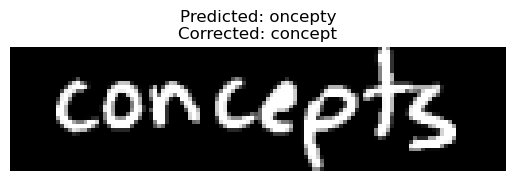

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


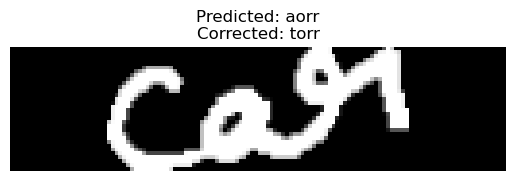

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


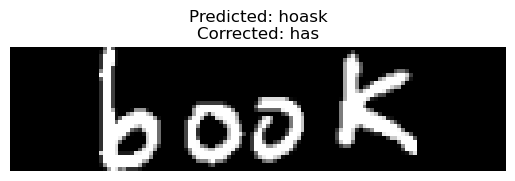

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


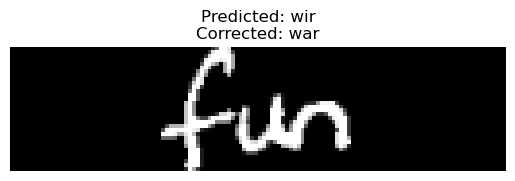

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


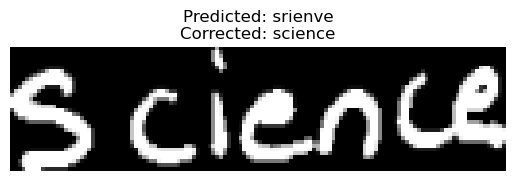

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


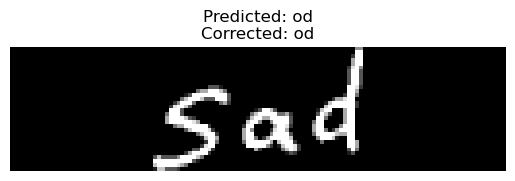

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


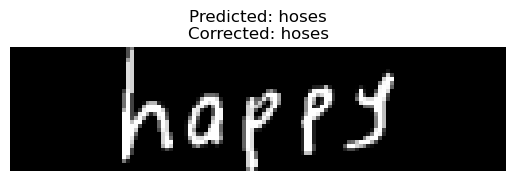

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


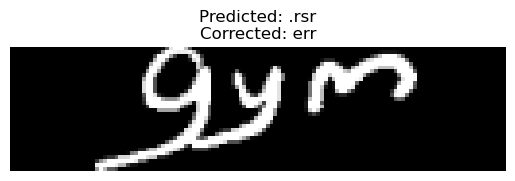

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


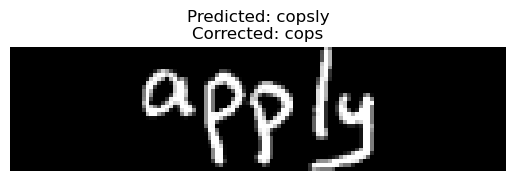

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


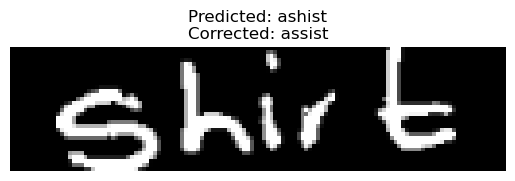

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


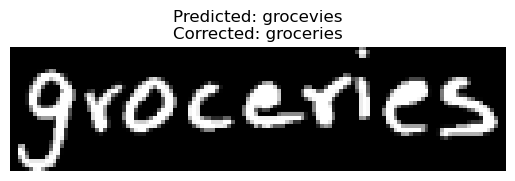

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


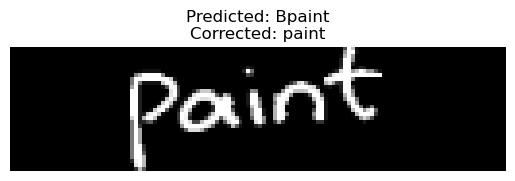

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


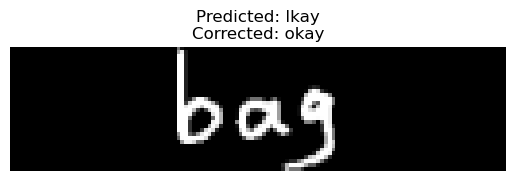

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


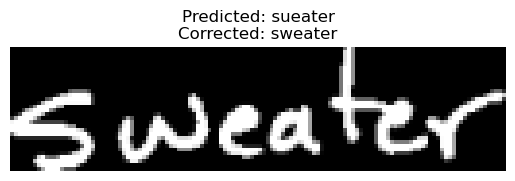

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


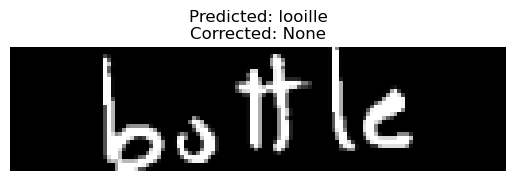

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


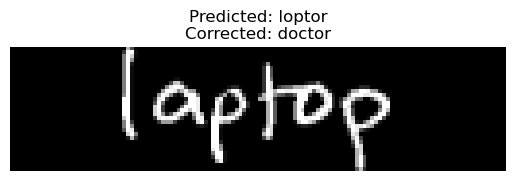

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


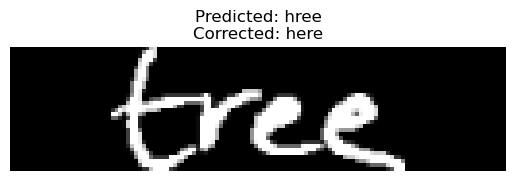

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


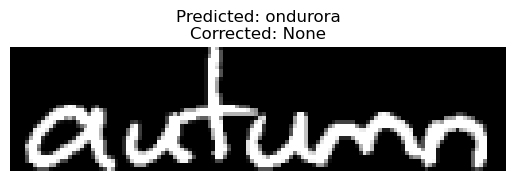

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


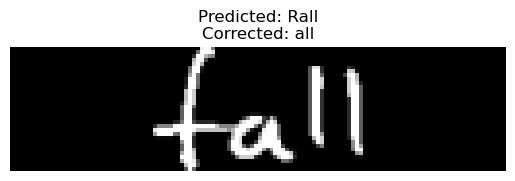

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


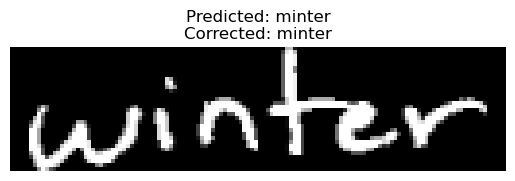

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


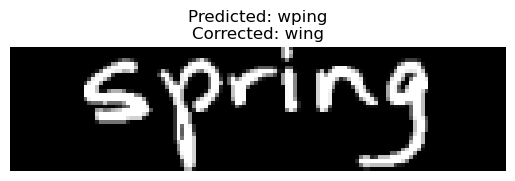

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


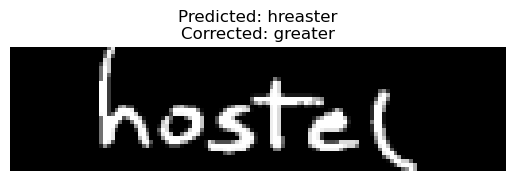

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


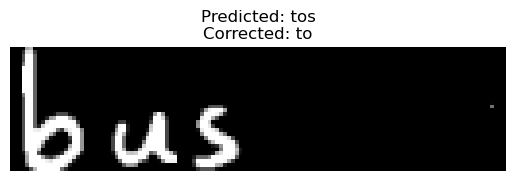

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


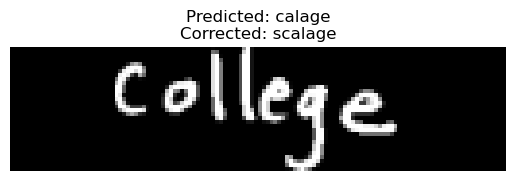

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


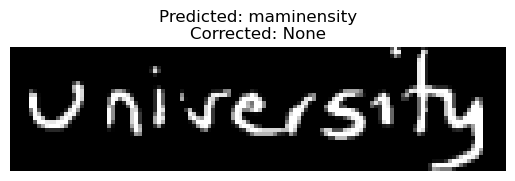

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


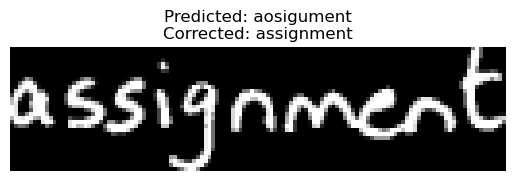

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


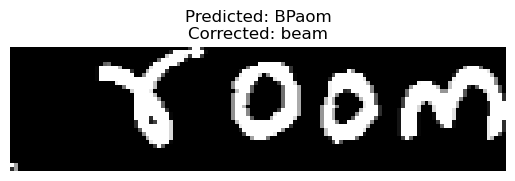

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


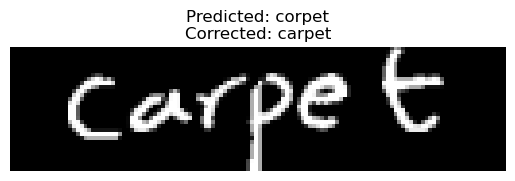

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


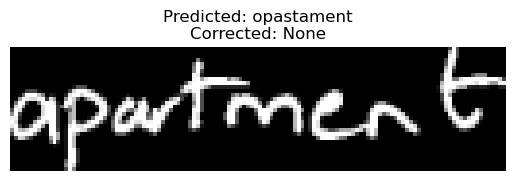

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


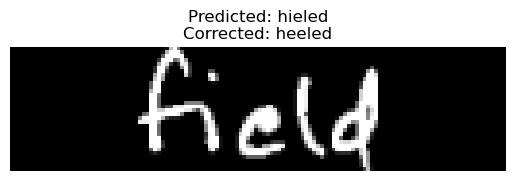

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


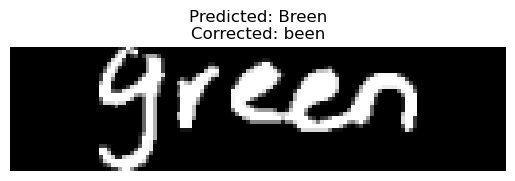

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


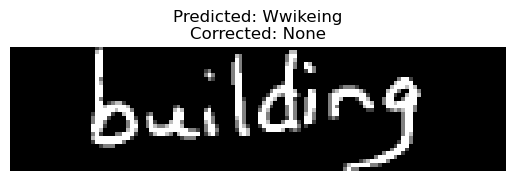

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


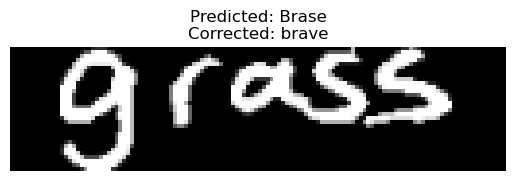

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


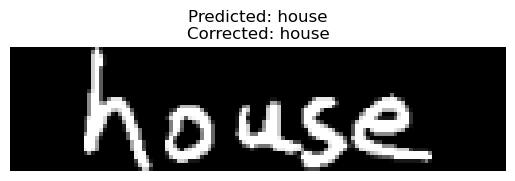

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


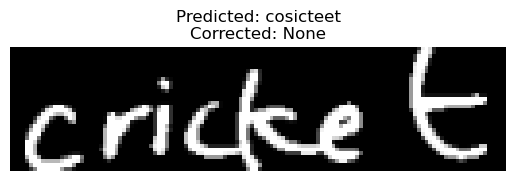

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


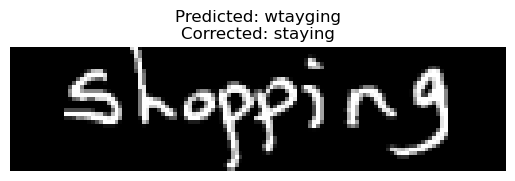

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


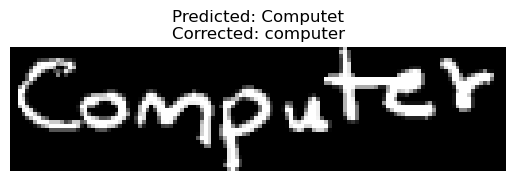

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


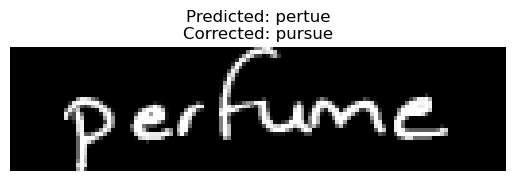

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


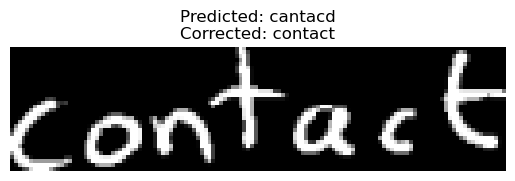

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


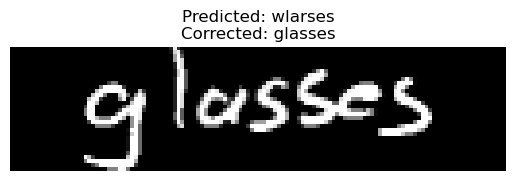

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


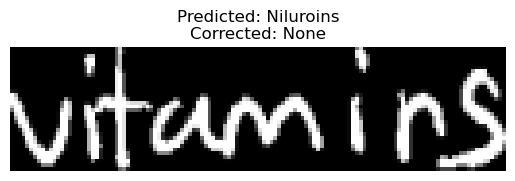

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


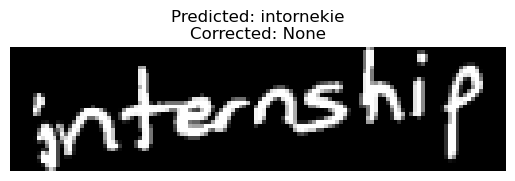

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


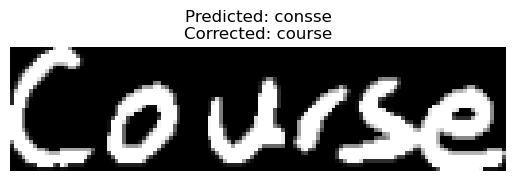

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


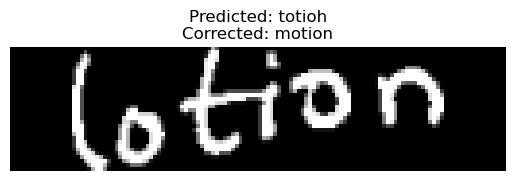

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


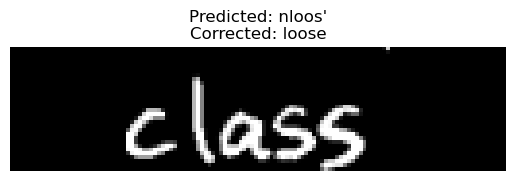

In [25]:
new_folder_path = r'C:\Users\sweth\Neural\DomainAdaptation\words2\words2'

corrected_texts = predict_and_display_new_images_with_pyspellchecker(
    act_model, char_list, spell_checker, folder_path=new_folder_path
)


SymSpell Algorithm with Greedy Decoding

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


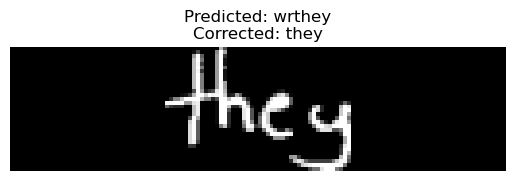

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


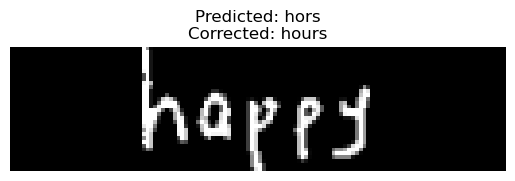

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


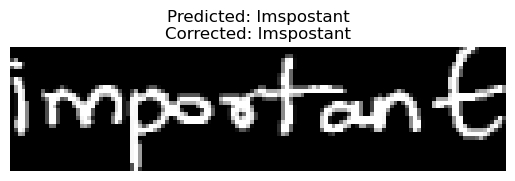

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


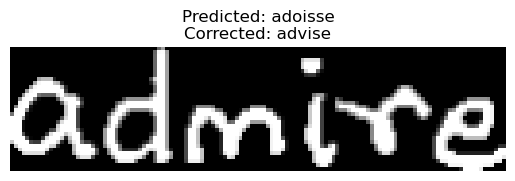

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


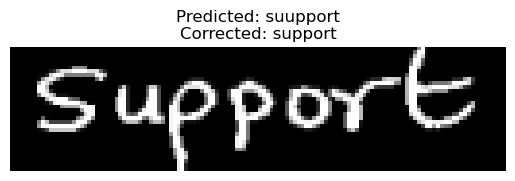

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


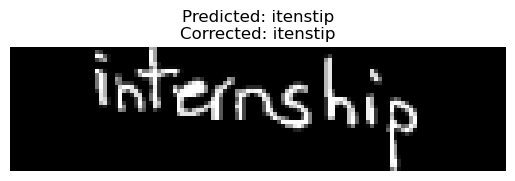

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


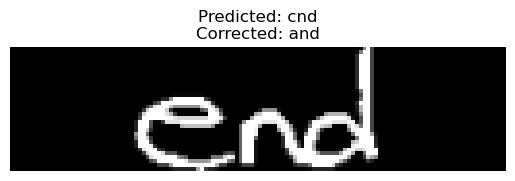

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


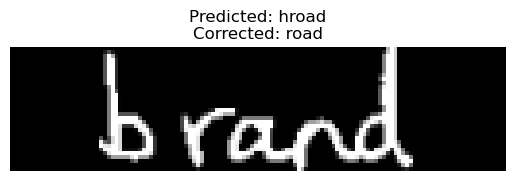

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


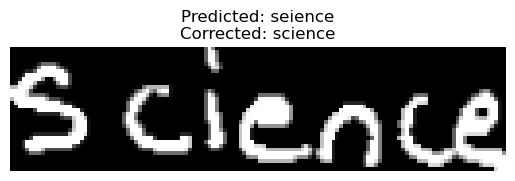

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


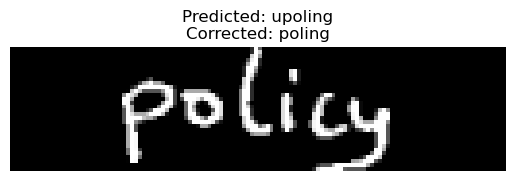

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


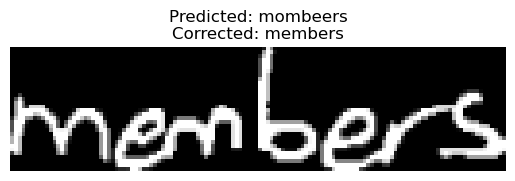

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


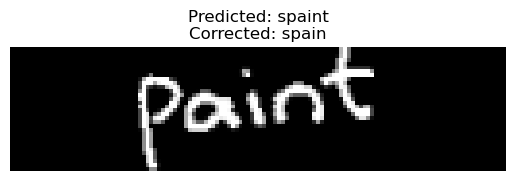

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


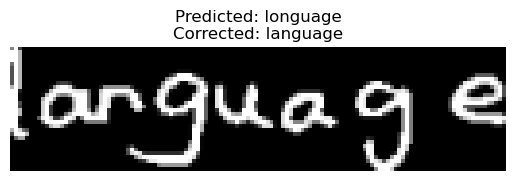

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


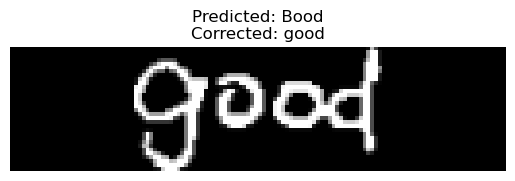

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


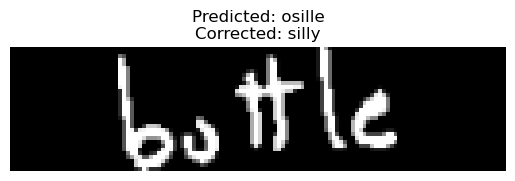

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


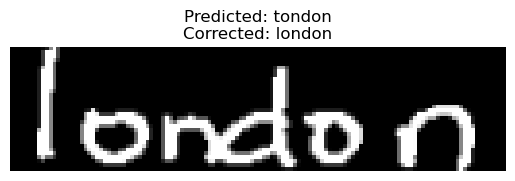

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


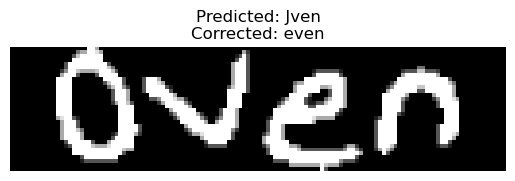

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


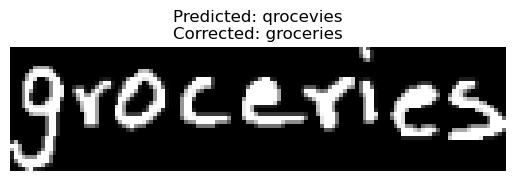

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


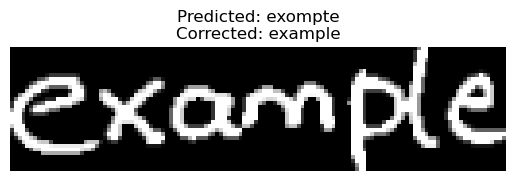

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


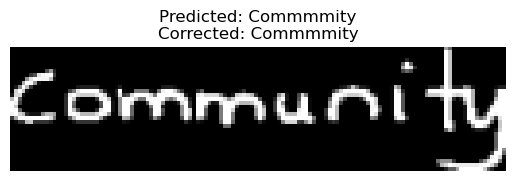

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


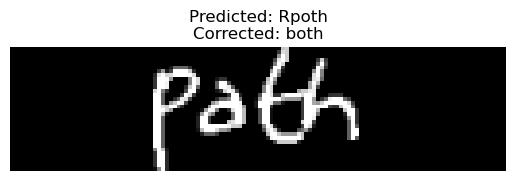

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


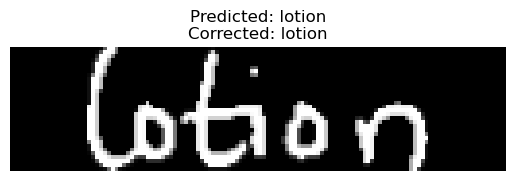

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


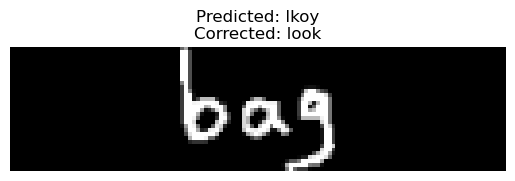

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


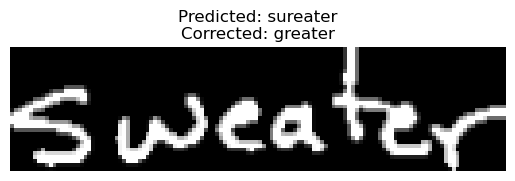

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


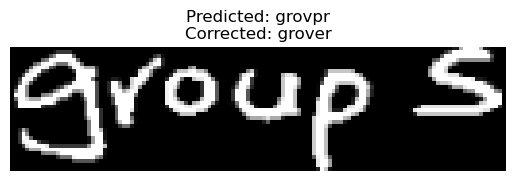

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


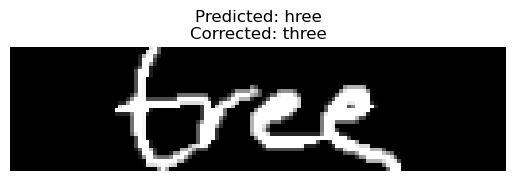

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


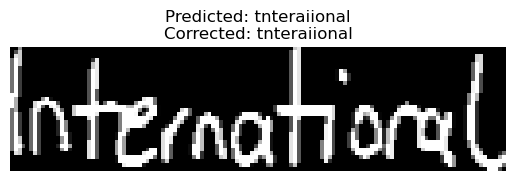

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


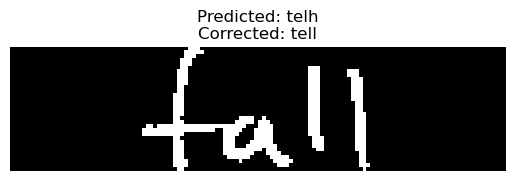

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


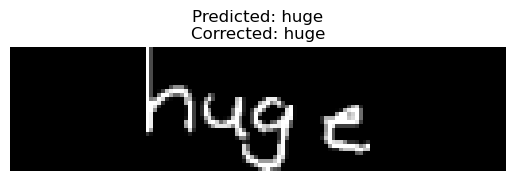

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


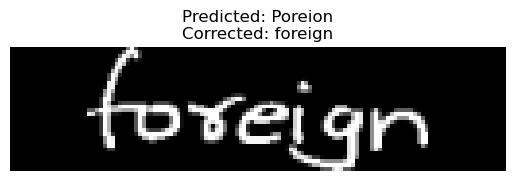

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


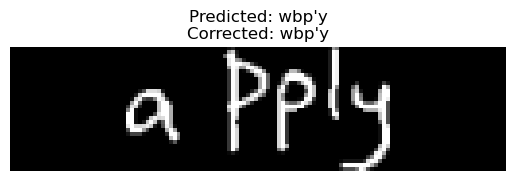

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


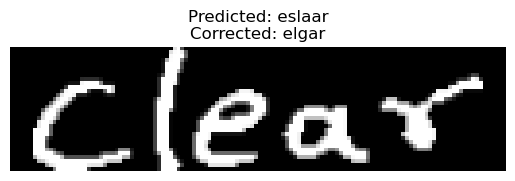

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


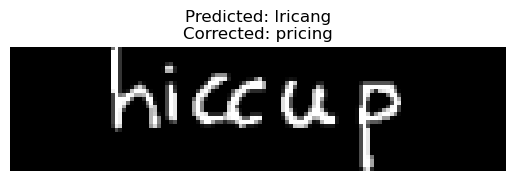

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


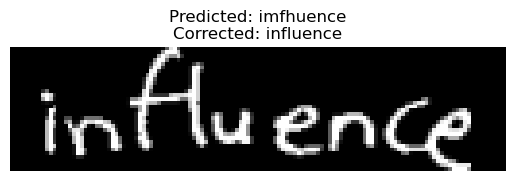

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


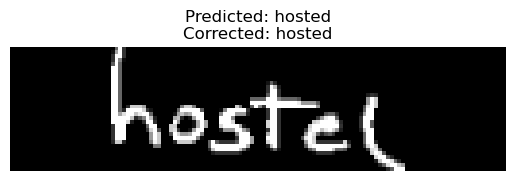

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


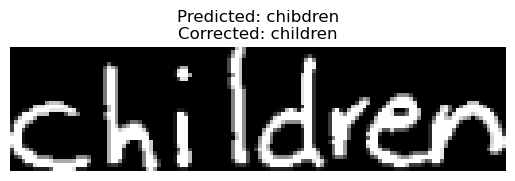

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


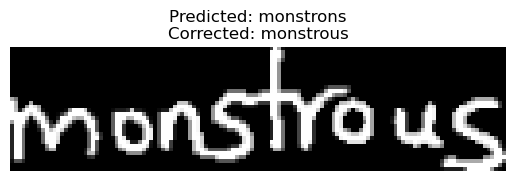

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


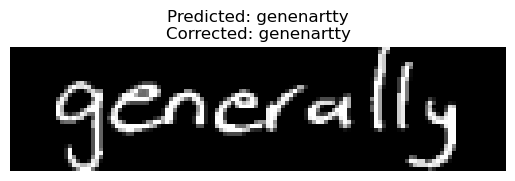

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


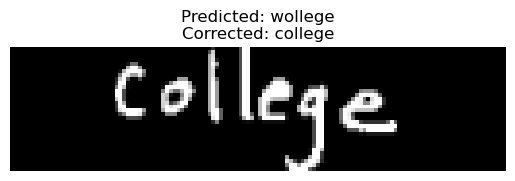

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


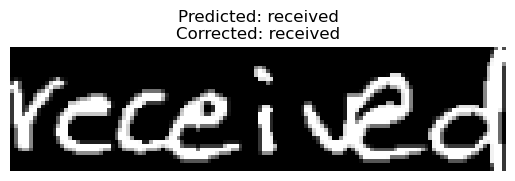

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


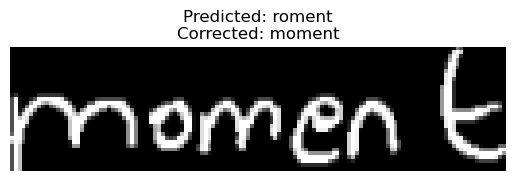

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


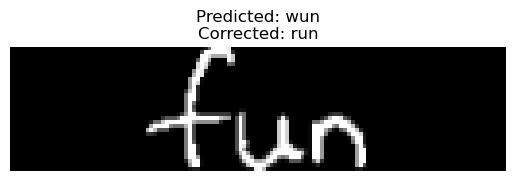

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


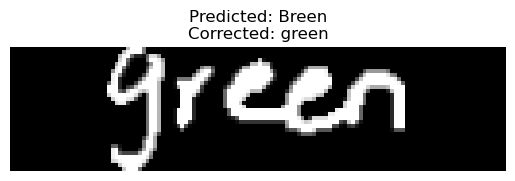

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


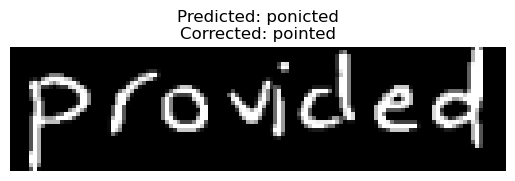

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


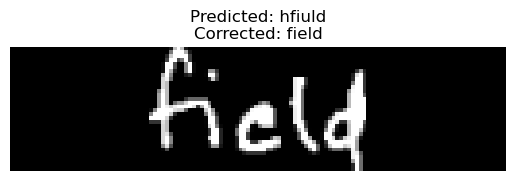

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


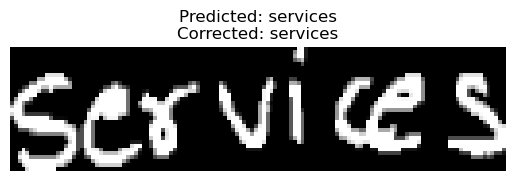

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


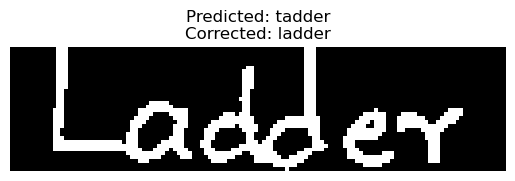

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


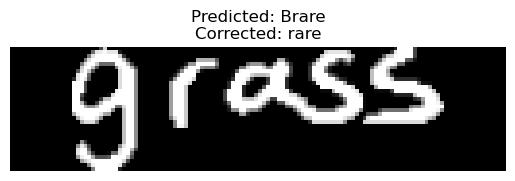

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


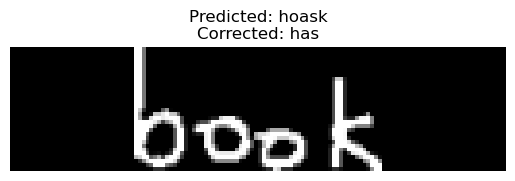

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


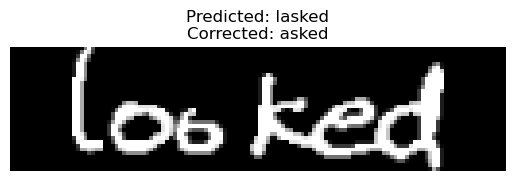

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


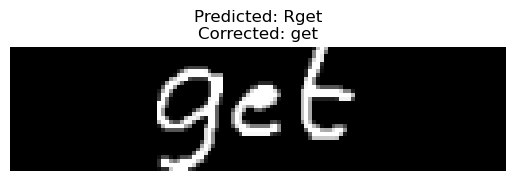

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


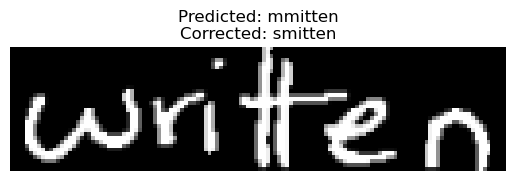

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


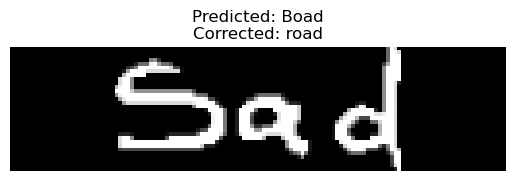

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


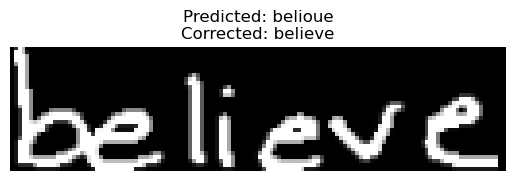

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


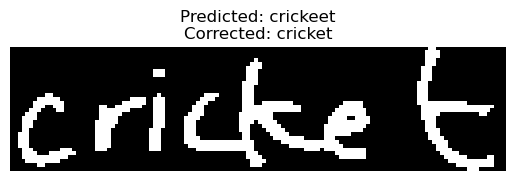

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


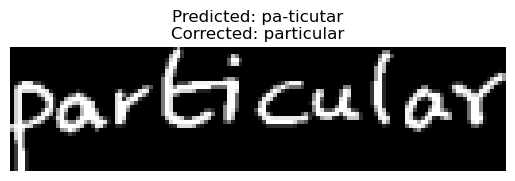

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


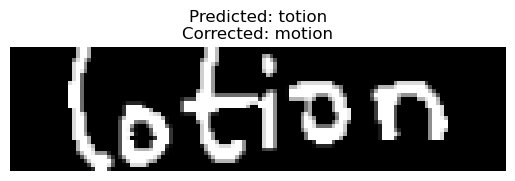

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


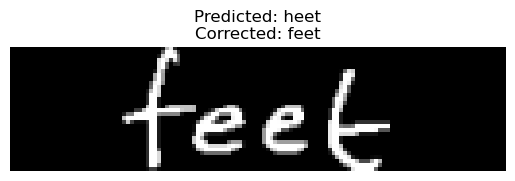

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


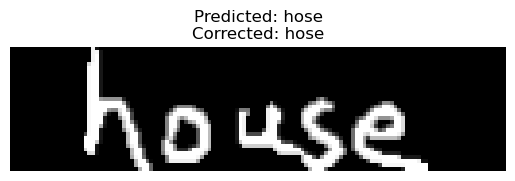

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


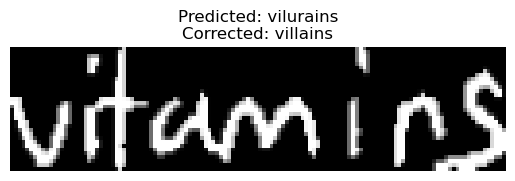

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


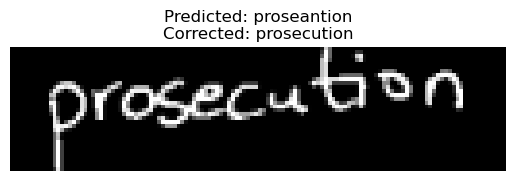

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


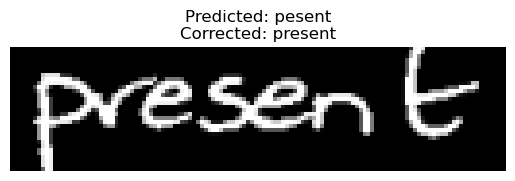

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


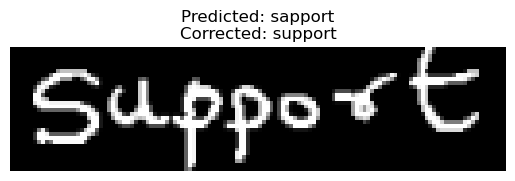

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


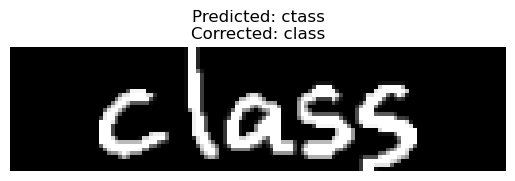

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


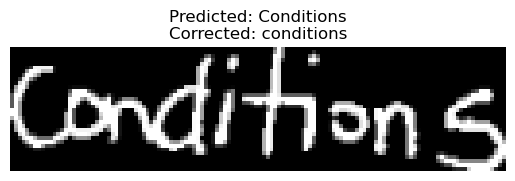

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


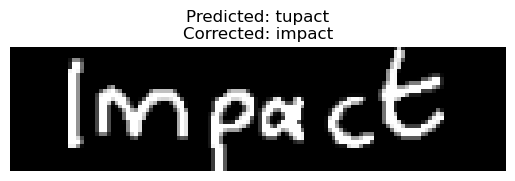

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


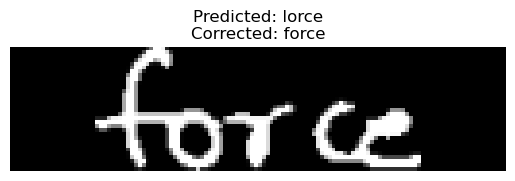

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


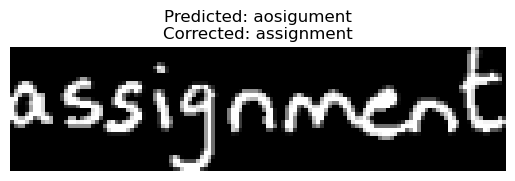

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


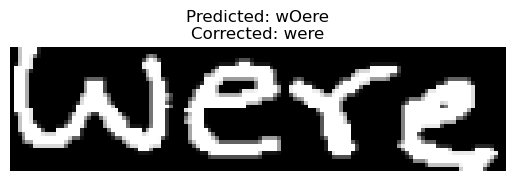

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


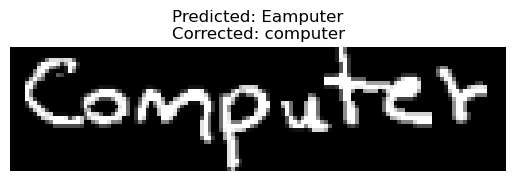

Character Error Rate (CER) - Predicted: 14.285714285714285%
Word Error Rate (WER) - Predicted: 100.0%
Character Error Rate (CER) - corrected : 24.43946188340807%
Word Error Rate (WER) - corrected: 48.57142857142857%


In [89]:
from difflib import SequenceMatcher

def correct_spelling_with_symspell(text, sym_spell):
    # Generate suggestions for corrections
    suggestions = sym_spell.lookup(text, Verbosity.TOP, max_edit_distance=2)
    # Return the best suggestion if available, or the original text
    return suggestions[0].term if suggestions else text

# Path to the folder containing new images
new_folder_path = r'C:\Users\sweth\Neural\DomainAdaptation\cer_words'

def preprocess_image(image_path):
    # Load the image in grayscale
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    # Invert colors to have white text on black background
    inverted = cv2.bitwise_not(img)

    # Apply thresholding for binarization
    _, binary = cv2.threshold(inverted, 150, 255, cv2.THRESH_BINARY)

    # Find the coordinates of non-zero pixels to crop tightly around the text
    coords = cv2.findNonZero(binary)  # Finds all non-zero (white) points
    if coords is not None:
        x, y, w, h = cv2.boundingRect(coords)  # Get the bounding box of non-zero points
        cropped_img = binary[y:y+h, x:x+w]  # Crop the image to the bounding box

        # Resize the cropped image to have a height of 32 pixels while maintaining aspect ratio
        target_height, target_width = 32, 128
        aspect_ratio = cropped_img.shape[1] / cropped_img.shape[0]
        new_width = min(target_width, int(aspect_ratio * target_height))
        resized_img = cv2.resize(cropped_img, (new_width, target_height), interpolation=cv2.INTER_AREA)

        # Calculate padding to center the text within the target dimensions
        pad_left = (target_width - resized_img.shape[1]) // 2
        pad_right = target_width - resized_img.shape[1] - pad_left

        # Add padding to create a consistent 32x128 image with centered text
        processed_img = cv2.copyMakeBorder(resized_img, 0, 0, pad_left, pad_right, cv2.BORDER_CONSTANT, value=0)

        # Normalize pixel values to [0, 1]
        img_normalized = processed_img / 255.0
        img_expanded = np.expand_dims(img_normalized, axis=-1)  # Add channel dimension

        return img_expanded  # Returns a 3D image
    else:
        # Return an empty array if no non-zero pixels found
        return np.zeros((32, 128, 1))


# def preprocess_image(image_path):
#     """
#     Preprocess the image to enhance handwritten text detection.
#     Converts to grayscale, applies noise removal, adaptive thresholding,
#     tight cropping, resizing, and padding to match model input dimensions.
#     """
#     # Load the image in grayscale
#     img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

#     if img is None:
#         raise FileNotFoundError(f"Image not found at {image_path}")

#     # Apply Gaussian Blur to reduce noise
#     blurred_img = cv2.GaussianBlur(img, (5, 5), 0)

#     # Adaptive thresholding for robust binarization
#     binary = cv2.adaptiveThreshold(
#         blurred_img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 15, 10
#     )

#     # Morphological operations to enhance text contours
#     kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
#     morphed = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel)

#     # Find non-zero pixel coordinates for cropping
#     coords = cv2.findNonZero(morphed)
#     if coords is not None:
#         x, y, w, h = cv2.boundingRect(coords)
#         cropped_img = morphed[y:y+h, x:x+w]

#         # Resize to target height (32) while preserving aspect ratio
#         target_height, target_width = 32, 128
#         aspect_ratio = cropped_img.shape[1] / cropped_img.shape[0]
#         new_width = min(target_width, int(aspect_ratio * target_height))
#         resized_img = cv2.resize(cropped_img, (new_width, target_height), interpolation=cv2.INTER_AREA)

#         # Pad to center the text in a 32x128 image
#         pad_left = (target_width - resized_img.shape[1]) // 2
#         pad_right = target_width - resized_img.shape[1] - pad_left
#         padded_img = cv2.copyMakeBorder(resized_img, 0, 0, pad_left, pad_right, cv2.BORDER_CONSTANT, value=0)

#         # Normalize pixel values to [0, 1] and expand channel dimension
#         normalized_img = padded_img / 255.0
#         img_expanded = np.expand_dims(normalized_img, axis=-1)

#         return img_expanded
#     else:
#         # Return an empty 32x128 black image if no text is detected
#         return np.zeros((32, 128, 1))

def calculate_cer(ground_truths, corrected_texts):
    total_chars = 0
    char_errors = 0
    for gt, pred in zip(ground_truths, corrected_texts):
        total_chars += len(gt)
        char_errors += sum(1 for g, p in zip(gt, pred) if g != p)
    cer = (char_errors / total_chars) * 100 if total_chars > 0 else 0
    return cer

def calculate_wer(ground_truths, corrected_texts):
    total_words = 0
    word_errors = 0
    for gt, pred in zip(ground_truths, corrected_texts):
        ground_words = gt.split()
        predicted_words = pred.split()
        total_words += len(ground_words)
        # Use SequenceMatcher to calculate the word errors
        matcher = SequenceMatcher(None, ground_words, predicted_words)
        word_errors += sum(1 for tag in matcher.get_opcodes() if tag[0] != 'equal')
    wer = (word_errors / total_words) * 100 if total_words > 0 else 0
    return wer

def predict_and_display_new_images_with_symspell(model, char_list, sym_spell, folder_path, ground_truths_dict):
    # Load new images from folder
    corrected_texts = []
    ground_truths = []
    for filename in os.listdir(folder_path):
        if filename.endswith(".png"):
            img_path = os.path.join(folder_path, filename)
            processed_img = preprocess_image(img_path)  # Process to (32, 128, 1) as expected by the model

            # Expand dimensions to match model input
            processed_img = np.expand_dims(processed_img, axis=0)  # Shape: (1, 32, 128, 1)

            # Predict using the trained model
            prediction = model.predict(processed_img)

            # Decode prediction using CTC decoder
            decoded = K.ctc_decode(prediction, input_length=np.ones(prediction.shape[0]) * prediction.shape[1])[0][0]
            out = K.get_value(decoded)

            # Convert decoded labels back to text
            predicted_text = ''.join([char_list[c] for c in out[0] if c != -1])

            # Correct the spelling of the predicted text using SymSpell
            corrected_text = correct_spelling_with_symspell(predicted_text, sym_spell)

            # Get the ground truth from the dictionary using the filename
            ground_truth = ground_truths_dict.get(filename, "")  # Default to "" if not found

            # Display the original processed image for visualization
            plt.imshow(processed_img[0, :, :, 0], cmap='gray')  # Display the processed image
            plt.axis('off')
            plt.title(f"Predicted: {predicted_text}\nCorrected: {corrected_text}")
            plt.show()

            # Append results to lists
            corrected_texts.append(corrected_text)
            ground_truths.append(ground_truth)
    
    cer_predicted = calculate_cer(ground_truths, predicted_texts)
    wer_predicted = calculate_wer(ground_truths, predicted_texts)
    # Calculate CER and WER
    cer = calculate_cer(ground_truths, corrected_texts)
    wer = calculate_wer(ground_truths, corrected_texts)

    print(f"Character Error Rate (CER) - Predicted: {cer_predicted}%")
    print(f"Word Error Rate (WER) - Predicted: {wer_predicted}%")
    print(f"Character Error Rate (CER) - corrected : {cer}%")
    print(f"Word Error Rate (WER) - corrected: {wer}%")

    return corrected_texts, predicted_text, ground_truths  # Return the corrected and ground truth texts

# Ground truth labels (manually written)
ground_truths_dict = {
    "word_1 (2).png": "they",
    "word_1.png": "happy",
    "word_2 (2).png": "example",
    "word_3 (2).png": "children",
    "word_3 (3).png": "biography",
    "word_3.png": "fun",
    "word_4 (2).png": "particular",
    "word_4.png": "lotion",
    "word_5 (2).png": "which",
    "word_5 (3).png": "prosecution",
    "word_6 (2).png": "present",
    "word_6 (3).png": "support",
    "word_6.png": "class",
    "word_7 (2).png": "conditions",
    "word_7 (3).png": "impact",
    "word_7.png": "car",
    "word_8 (2).png": "force",
    "word_8.png": "assignment",
    "word_9 (2).png": "were",
    "word_9.png": "computer",
    "word_10 (2).png": "important",
    "word_10 (3).png": "admire",
    "word_10.png": "course",
    "word_11 (2).png": "support",
    "word_11 (3).png": "internship",
    "word_12 (2).png": "end",
    "word_12 (3).png": "brand",
    "word_12.png": "concepts",
    "word_14.png": "science",
    "word_15 (2).png": "policy",
    "word_16 (2).png": "members",
    "word_16.png": "paint",
    "word_17 (2).png": "language",
    "word_17 (3).png": "good",
    "word_17.png": "bottle",
    "word_18.png": "black",
    "word_18 (3).png": "car",
    "word_19 (2).png": "london",
    "word_19 (3).png": "oven",
    "word_19.png": "groceries",
    "word_20 (2).png": "community",
    "word_20 (3).png": "path",
    "word_20.png": "laptop",
    "word_21 (3).png": "lotion",
    "word_21.png": "bag",
    "word_22 (3).png": "glove",
    "word_22.png": "sweater",
    "word_23 (2).png": "groups",
    "word_23 (3).png": "wage",
    "word_23.png": "tree",
    "word_24 (2).png": "west",
    "word_24.png": "autumn",
    "word_25 (2).png": "international",
    "word_25.png": "fall",
    "word_26 (2).png": "huge",
    "word_26.png": "foreign",
    "word_27 (2).png": "apply",
    "word_27.png": "clear",
    "word_28 (2).png": "hiccup",
    "word_28.png": "spring",
    "word_29 (2).png": "influence",
    "word_29.png": "hostel",
    "word_30 (2).png": "modern",
    "word_30 (3).png": "monstrous",
    "word_31 (2).png": "generally",
    "word_31 (3).png": "socialist",
    "word_31.png": "college",
    "word_32 (2).png": "received",
    "word_33 (2).png": "moment",
    "word_33 (3).png": "fun",
    "word_33.png": "green",
    "word_34 (2).png": "provided",
    "word_34 (3).png": "journal",
    "word_34.png": "field",
    "word_35 (2).png": "services",
    "word_35 (3).png": "Ladder",
    "word_35.png": "grass",
    "word_36 (3).png": "book",
    "word_36.png": "carpet",
    "word_37 (2).png": "looked",
    "word_37 (3).png": "get",
    "word_37.png": "apartment",
    "word_38 (2).png": "written",
    "word_38 (3).png": "sad",
    "word_39 (2).png": "believe",
    "word_39.png": "cricket",
    "word_40 (2).png": "feet",
    "word_40.png": "house",
    "word_42 (2).png": "relationship",
    "word_42.png": "glasses",
    "word_43.png": "vitamins",
    "word_44.png": "contact"

}


corrected_texts, predicted_texts, ground_truths = predict_and_display_new_images_with_symspell(
    act_model, char_list, sym_spell, folder_path=new_folder_path, ground_truths_dict=ground_truths_dict
)
